In [102]:

import numpy as np 
import pandas as pd 
import os


In [2]:
from pathlib import Path
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Activation
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import cv2
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
data_dir = Path('../input/fer2018/fer20131.csv')

In [4]:
train_data = pd.read_csv(data_dir)

In [5]:
train_data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
train_data = train_data.drop(['Usage'],axis=1)


In [51]:
width , height = 48,48
image_size=(48,48)


        
pixels = train_data['pixels'].tolist()
        
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    face = np.stack((face,)*3, -1)
    faces.append(face.astype('uint8'))
faces = np.asarray(faces)

#for face in faces:
    #face = face.astype('float32')
    #face = face / 255.0
    

In [52]:
faces.shape

#emotion.shape

(35887, 48, 48, 3)

In [53]:

emotion = train_data.iloc[:,:-1]
emotion = np.array(emotion)
num_classes=7
emotion = np_utils.to_categorical(emotion,num_classes)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotion,
                                                    test_size=0.1,
                                                    random_state=41,
                                                    stratify=emotion)

In [57]:
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


In [58]:
shape = (48,48,3)
model = mini_XCEPTION(shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 46, 46, 8)    216         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 46, 46, 8)    32          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 46, 46, 8)    0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_9 (

In [59]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [60]:
early_stop = EarlyStopping('val_loss', patience=50)
callbacks = [early_stop]


In [101]:
model.fit_generator(data_generator.flow(X_train, y_train,
                                            batch_size=32),
                        steps_per_epoch=len(X_train) / 32,
                        epochs=100, verbose=1, callbacks=callbacks,
                        validation_data=(X_test,y_test))

Epoch 1/100
1010/1009 [==============================] - 46s 45ms/step - loss: 1.0919 - acc: 0.5916 - val_loss: 1.1342 - val_acc: 0.5821
Epoch 2/100
1010/1009 [==============================] - 45s 44ms/step - loss: 1.0878 - acc: 0.5932 - val_loss: 1.2043 - val_acc: 0.5673
Epoch 3/100
1010/1009 [==============================] - 44s 44ms/step - loss: 1.0778 - acc: 0.5960 - val_loss: 1.1387 - val_acc: 0.5784
Epoch 4/100
1010/1009 [==============================] - 43s 43ms/step - loss: 1.0687 - acc: 0.6005 - val_loss: 1.1088 - val_acc: 0.5985
Epoch 5/100
1010/1009 [==============================] - 43s 43ms/step - loss: 1.0613 - acc: 0.6014 - val_loss: 1.1501 - val_acc: 0.5709
Epoch 6/100
1010/1009 [==============================] - 44s 44ms/step - loss: 1.0496 - acc: 0.6079 - val_loss: 1.2825 - val_acc: 0.5542
Epoch 7/100
1010/1009 [==============================] - 45s 44ms/step - loss: 1.0493 - acc: 0.6063 - val_loss: 1.1154 - val_acc: 0.6027
Epoch 8/100
1010/1009 [==================

KeyboardInterrupt: 

In [63]:
scores = model.evaluate(X_test, y_test,
                              batch_size=32)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

3589/3589 [==============================] - 1s 155us/step
Loss: 1.2654419829500654
Accuracy: 0.5260518250541124


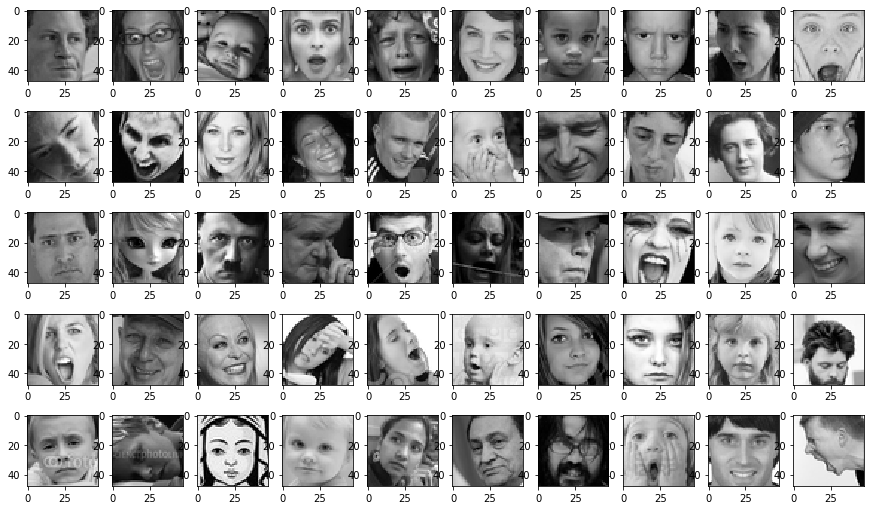

In [65]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    #plt.title(y_train[i])
    
    plt.imshow(X_test[i].reshape(48,48,3))

1/1 [==============================] - 0s 5ms/step
surprise


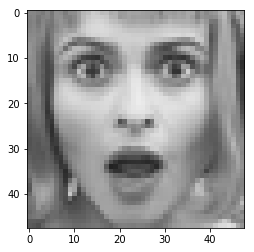

In [100]:
emotions = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',4: 'sad', 5: 'surprise', 6: 'neutral'}
plt.imshow(X_test[3].reshape(48,48,3))
pred = model.predict(X_test[3].reshape(1,48,48,3), verbose=1)

print(emotions[np.argmax(pred)])